# Tweet sentiment extraction
With all of the tweets circulating every second it is hard to tell whether the sentiment behind a specific tweet will impact a company, or a person's, brand for being viral (positive), or devastate profit because it strikes a negative tone. Capturing sentiment in language is important in these times where decisions and reactions are created and updated in seconds. But, which words actually lead to the sentiment description?

## What should I expect the data format to be?
Each row contains the text of a tweet and a sentiment label. In the training set you are provided with a word or phrase drawn from the tweet (selected_text) that encapsulates the provided sentiment.

## What am I predicting?
I am attempting to predict the word or phrase from the tweet that exemplifies the provided sentiment. The format is as follows:

"id","word or phrase that supports the sentiment"

In [1]:
import nltk
#nltk.download('stopwords')
#nltk.download('punkt')

import pandas as pd
import numpy as np
import os

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import plotly.express as px

from nltk.corpus import stopwords
from nltk.util import ngrams

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import RidgeClassifier
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.ensemble import RandomForestClassifier

from collections import defaultdict, Counter
from itertools import chain

plt.style.use('ggplot')
stop=set(stopwords.words('english'))

import re
from nltk.tokenize import word_tokenize
import gensim
import string

from tqdm import tqdm
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM,Dense, SpatialDropout1D, Dropout, Input
from keras.initializers import Constant
from keras.optimizers import Adam

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_hub as hub


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/carcrupe/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/carcrupe/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/home/carcrupe/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [234]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
print('There are {} rows and {} columns in train'.format(train_df.shape[0],train_df.shape[1]))
print('There are {} rows and {} columns in train'.format(test_df.shape[0],test_df.shape[1]))

# Dataset is now stored in a Pandas Dataframe

There are 27481 rows and 4 columns in train
There are 3534 rows and 3 columns in train


In [235]:
train_df.head(10)

textID                                               text  \
0  cb774db0d1                I`d have responded, if I were going   
1  549e992a42      Sooo SAD I will miss you here in San Diego!!!   
2  088c60f138                          my boss is bullying me...   
3  9642c003ef                     what interview! leave me alone   
4  358bd9e861   Sons of ****, why couldn`t they put them on t...   
5  28b57f3990  http://www.dothebouncy.com/smf - some shameles...   
6  6e0c6d75b1  2am feedings for the baby are fun when he is a...   
7  50e14c0bb8                                         Soooo high   
8  e050245fbd                                        Both of you   
9  fc2cbefa9d   Journey!? Wow... u just became cooler.  hehe....   

                                       selected_text sentiment  
0                I`d have responded, if I were going   neutral  
1                                           Sooo SAD  negative  
2                                        bullying me  negative  
3                                     leave me alone  negative  
4                                      Sons of ****,  negative  
5  http://www.dothebouncy.com/smf - some shameles...   neutral  
6                                                fun  positive  
7                                         Soooo high   neutral  
8                                        Both of you   neutral  
9                       Wow... u just became cooler.  positive

In [236]:
train_df['sentiment'].unique()

array(['neutral', 'negative', 'positive'], dtype=object)

In [237]:
test_df.head(10)

textID                                               text sentiment
0  f87dea47db  Last session of the day  http://twitpic.com/67ezh   neutral
1  96d74cb729   Shanghai is also really exciting (precisely -...  positive
2  eee518ae67  Recession hit Veronique Branquinho, she has to...  negative
3  01082688c6                                        happy bday!  positive
4  33987a8ee5             http://twitpic.com/4w75p - I like it!!  positive
5  726e501993                    that`s great!! weee!! visitors!  positive
6  261932614e            I THINK EVERYONE HATES ME ON HERE   lol  negative
7  afa11da83f   soooooo wish i could, but im in school and my...  negative
8  e64208b4ef   and within a short time of the last clue all ...   neutral
9  37bcad24ca   What did you get?  My day is alright.. haven`...   neutral

In [238]:
print('Null Values: \n')
print('Train', train_df.isna().sum(), end='\n\n', sep='\n\n')
print('Empty text: ',(train_df['text']=='').sum(), end='\n')
print('Empty selected text: ',(train_df['selected_text']=='').sum(), end='\n\n')
print('Test', test_df.isna().sum(), sep='\n\n')

Null Values: 

Train

textID           0
text             1
selected_text    1
sentiment        0
dtype: int64

Empty text:  0
Empty selected text:  0

Test

textID       0
text         0
sentiment    0
dtype: int64


In [239]:
train_df.dropna(inplace=True) # drop NaN values
#train_df.head(10)

In [240]:
positive_len = train_df[train_df['sentiment'] == 'positive'].shape[0]
negative_len = train_df[train_df['sentiment'] == 'negative'].shape[0]
neutral_len = train_df[train_df['sentiment'] == 'neutral'].shape[0]

#Create a column with tweet original length
len_tweet = [len(str(line)) for line in train_df['text']]
train_df['length_original_chars']=len_tweet

In [241]:
df = train_df.groupby('sentiment')['length_original_chars'].count().reset_index()
df

sentiment  length_original_chars
0  negative                   7781
1   neutral                  11117
2  positive                   8582

In [242]:
fig = px.funnel_area(df, names='sentiment', values='length_original_chars', 
                    width=500, height=300, color='sentiment', 
                    hover_data=['sentiment', 'length_original_chars'])

fig.update_layout(legend_title='<b> Sentiment </b>', title='Sentiment distribution')
fig.show()

Text(0.5, 1.0, 'Proportion of sentiments')

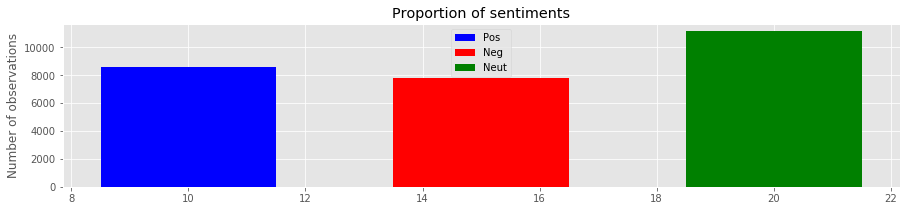

In [243]:
plt.bar(10,positive_len,3, label="Pos", color='blue')
plt.bar(15,negative_len,3, label="Neg", color='red')
plt.bar(20,neutral_len,3, label="Neut", color='green')

plt.legend()
plt.ylabel('Number of observations')
plt.title('Proportion of sentiments')

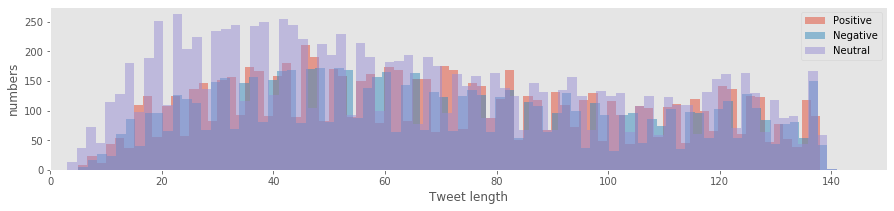

In [244]:
plt.rcParams['figure.figsize'] = (15.0, 3.0)
plt.hist(train_df[train_df['sentiment'] == 'positive']['length_original_chars'],alpha=0.5, bins=80, label='Positive');
plt.hist(train_df[train_df['sentiment'] == 'negative']['length_original_chars'],alpha=0.5, bins=80, label='Negative');
plt.hist(train_df[train_df['sentiment'] == 'neutral']['length_original_chars'],alpha=0.5, bins=80, label='Neutral');

plt.xlabel('Tweet length')
plt.ylabel('numbers')
plt.legend(loc='upper right')
plt.xlim(0,150)
plt.grid()

In [245]:
#Count the number of words in each tweet in a separated histrogram
words_in_positive_tweet = [len(word_tokenize(line)) for line in train_df[train_df['sentiment'] == 'positive']['text']]
words_in_negative_tweet = [len(word_tokenize(line)) for line in train_df[train_df['sentiment'] == 'negative']['text']]
words_in_neutral_tweet = [len(word_tokenize(line)) for line in train_df[train_df['sentiment'] == 'neutral']['text']]

Text(0.5, 1.0, 'Neutral tweets - number of words')

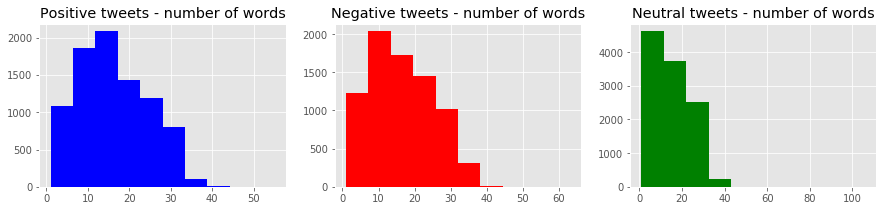

In [246]:
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(15,3))
ax1.hist(words_in_positive_tweet, color='b');
ax1.set_title('Positive tweets - number of words')

ax2.hist(words_in_negative_tweet, color='r');
ax2.set_title('Negative tweets - number of words')

ax3.hist(words_in_neutral_tweet, color='g');
ax3.set_title('Neutral tweets - number of words')

(0, 40)

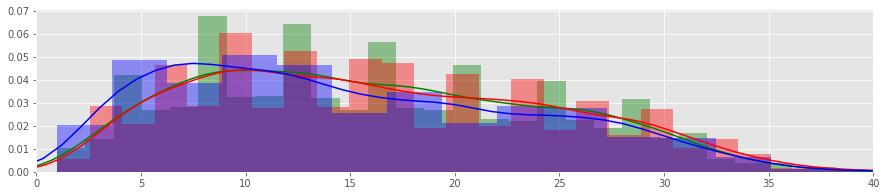

In [247]:
plt.figure(figsize=(15,3))
sns.distplot(words_in_positive_tweet, label='positive', bins=40, color='g')
sns.distplot(words_in_negative_tweet,label='negative', bins=40, color='r')
sns.distplot(words_in_neutral_tweet, label='neutral', bins=40, color='b')
plt.xlim(0,40)

In [249]:
# I create a jaccard similarity column between text and selected text

In [250]:
def jaccard(str1, str2): 
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))


In [251]:
train_df['jaccard_similarity'] = train_df.apply(lambda x: jaccard(x['text'], x['selected_text']), axis=1)

## Let us remove punctuation, emojis, stop words and not needed prefixes or URLs
### Apply to train and test text

In [252]:
def remove_stopwords(words):
    STOP_WORDS = set(nltk.corpus.stopwords.words('english'))
    STOP_WORDS.remove('not')
    sentence = []
    for w in words:
        if w not in STOP_WORDS:
            sentence.append(w)
    return sentence

In [253]:
#Remove Emojis
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [254]:
# Dictionary with all abreviations, we will use it to convert words and improve the training phase
# Thanks to https://www.kaggle.com/rftexas/text-only-kfold-bert
abbreviations = {
    "$" : " dollar ",
    "â‚¬" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", #"que pasa",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

In [255]:
# Thanks to https://www.kaggle.com/rftexas/text-only-kfold-bert
def convert_abbrev(word):
    return abbreviations[word.lower()] if word.lower() in abbreviations.keys() else word

In [256]:
# Thanks to https://www.kaggle.com/rftexas/text-only-kfold-bert
def convert_abbrev_in_text(text):
    tokens = word_tokenize(text)
    tokens = [convert_abbrev(word) for word in tokens]
    text = ' '.join(tokens)
    return text

In [257]:
def clean_text(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation.replace("'", '')), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = remove_emoji(text)
    text = convert_abbrev_in_text(text)
    # tokenizer words and join
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    words = tokenizer.tokenize(text)
    words = remove_stopwords(words)
    text = ' '.join(words)
    # remove apostrophe 
    text = re.sub('[%s]' % re.escape("'"), '', text)
    return text


In [258]:
# Applying the cleaning function to both test and training datasets
train_df['text'] = train_df['text'].apply(clean_text)
train_df['selected_text'] = train_df['selected_text'].apply(clean_text)

In [259]:
train_df.head(10)

textID                                         text  \
0  cb774db0d1                           id responded going   
1  549e992a42                      sooo sad miss san diego   
2  088c60f138                                boss bullying   
3  9642c003ef                        interview leave alone   
4  358bd9e861     sons couldnt put releases already bought   
5  28b57f3990  shameless plugging best rangers forum earth   
6  6e0c6d75b1                feedings baby fun smiles coos   
7  50e14c0bb8                                   soooo high   
8  e050245fbd                                                
9  fc2cbefa9d      journey wow became cooler hehe possible   

                                 selected_text sentiment  \
0                           id responded going   neutral   
1                                     sooo sad  negative   
2                                     bullying  negative   
3                                  leave alone  negative   
4                                         sons  negative   
5  shameless plugging best rangers forum earth   neutral   
6                                          fun  positive   
7                                   soooo high   neutral   
8                                                neutral   
9                            wow became cooler  positive   

   length_original_chars  jaccard_similarity  
0                     36            1.000000  
1                     46            0.200000  
2                     25            0.166667  
3                     31            0.600000  
4                     75            0.214286  
5                     92            1.000000  
6                     64            0.071429  
7                     10            1.000000  
8                     12            1.000000  
9                     69            0.500000

Now that the texts are clean, let us count words and characters to compare text with the selected text

In [260]:
train_df['length_text_in_chars'] = [(len(line)) for line in train_df['text']]
train_df['length_selected_text_in_chars'] = [(len(line)) for line in train_df['selected_text']]
train_df['length_text_in_words'] = [len(word_tokenize(line)) for line in train_df['text']]
train_df['length_selected_text_in_words'] = [len(word_tokenize(line)) for line in train_df['selected_text']]

In [263]:
train_df.head()

textID                                      text       selected_text  \
0  cb774db0d1                        id responded going  id responded going   
1  549e992a42                   sooo sad miss san diego            sooo sad   
2  088c60f138                             boss bullying            bullying   
3  9642c003ef                     interview leave alone         leave alone   
4  358bd9e861  sons couldnt put releases already bought                sons   

  sentiment  length_original_chars  jaccard_similarity  length_text_in_chars  \
0   neutral                     36            1.000000                    18   
1  negative                     46            0.200000                    23   
2  negative                     25            0.166667                    13   
3  negative                     31            0.600000                    21   
4  negative                     75            0.214286                    40   

   length_selected_text_in_chars  length_text_in_words  \
0                             18                     3   
1                              8                     5   
2                              8                     2   
3                             11                     3   
4                              4                     6   

   length_selected_text_in_words  
0                              3  
1                              2  
2                              1  
3                              2  
4                              1

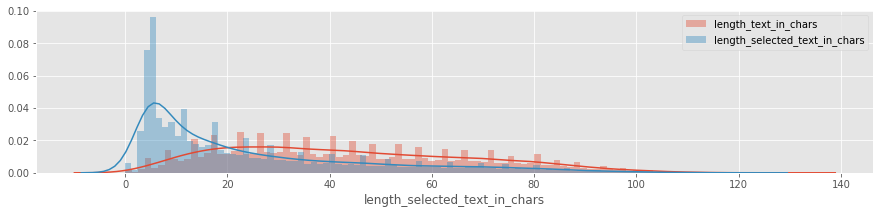

In [280]:
sns.distplot(train_df['length_text_in_chars'], bins=100, label='length_text_in_chars');
sns.distplot(train_df['length_selected_text_in_chars'], bins=100, label='length_selected_text_in_chars');
plt.legend();

In [284]:
px.histogram(train_df, x='jaccard_similarity', color='sentiment', 
             hover_data=train_df.columns,
             width=800, 
             height=300, title='Jaccard similarity scores')

In [308]:
# It is interesting to see that a high percentage of neutral text and neutral selected text are very similar length 
# Let us calculate this percentage for similarities higher than 90%

high_jaccard = train_df[train_df['jaccard_similarity'] > 0.9]
high_jaccard_group = high_jaccard.groupby('sentiment')['jaccard_similarity'].count()
high_jaccard_group

sentiment
negative     1179
neutral     10319
positive     1165
Name: jaccard_similarity, dtype: int64

In [313]:
sim_negative = high_jaccard_group['negative'] / len(train_df[train_df['sentiment']=='negative'])
sim_neutral = high_jaccard_group['neutral'] / len(train_df[train_df['sentiment']=='neutral'])
sim_positive = high_jaccard_group['positive'] / len(train_df[train_df['sentiment']=='positive'])


We might consider using text instead of selected text for neutral tweets, since the similarity is really high

Text(0.5, 1.0, 'Distribution of high jaccard similarity')

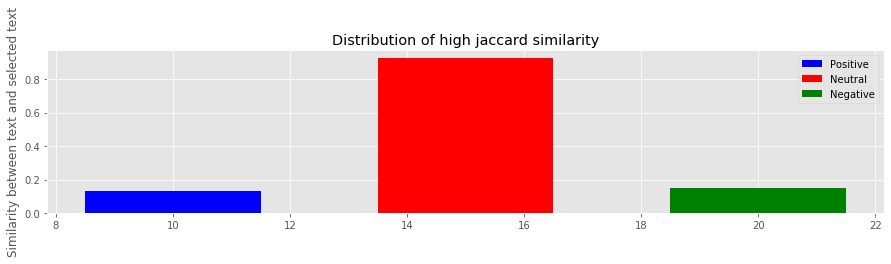

In [315]:
plt.bar(10,sim_positive,3, label="Positive", color='blue')
plt.bar(15,sim_neutral,3, label="Neutral", color='red')
plt.bar(20,sim_negative,3, label="Negative", color='green')

plt.legend()
plt.ylabel('Similarity between text and selected text')
plt.title('Distribution of high jaccard similarity')

After checking the word distribution and similarities, let us check most common words for each type of sentiment

In [316]:
df = pd.DataFrame(Counter(
            chain.from_iterable(train_df.selected_text.str.split())).most_common(20), 
                 columns=['words', 'counts'])

fig = px.bar(df, x="counts", y="words", 
             title='Most commmon words in selected text', 
             orientation='h', width=800, height=500, color='words')
fig.show()

In [318]:
positive_tweets = train_df[train_df['sentiment']=='positive']
negative_tweets = train_df[train_df['sentiment']=='negative']
neutral_tweets = train_df[train_df['sentiment']=='neutral']

In [323]:
df_positive = pd.DataFrame(Counter(
            chain.from_iterable(positive_tweets.selected_text.str.split())).most_common(20), 
                 columns=['words', 'counts'])

fig = px.bar(df_positive, x="counts", y="words", 
             title='Most commmon words in positive text', 
             orientation='h', width=800, height=500, color='words')
fig.show()

In [324]:
df_positive = pd.DataFrame(Counter(
            chain.from_iterable(negative_tweets.selected_text.str.split())).most_common(20), 
                 columns=['words', 'counts'])

fig = px.bar(df_positive, x="counts", y="words", 
             title='Most commmon words in negative text', 
             orientation='h', width=800, height=500, color='words')
fig.show()

In [325]:
df_positive = pd.DataFrame(Counter(
            chain.from_iterable(neutral_tweets.selected_text.str.split())).most_common(20), 
                 columns=['words', 'counts'])

fig = px.bar(df_positive, x="counts", y="words", 
             title='Most commmon words in neutral text', 
             orientation='h', width=800, height=500, color='words')
fig.show()